## Hierarchical dendrogram analysis based on the Bray-Curtis dissimilarity matrix on abundance data

Approximation to dendrogram analyis using the genus-level abundance data for hierarchical dendogram analyis based on the Bray-Curtis disimilarity matrix. While this approach may not provide the same level of resolution as the raw 16S rRNA sequences, it can still provide insights into the differences between samples and their relationships to different TL categories.
1. Data Normalisation
2. The Bray-Curtis dissimilarity matrix is calculated using our genus abundance data. 
3. Performing hierarchical clustering using the dissimilarity matrix. Using linkage method (e.g., average, complete, or Ward's linkage) based on the characteristics of our data.
4. Visualization of the resulting dendrogram and analyze the sample clusters in the context of the TL categories. 
5. Identifycation any patterns or associations between the dendrogram clusters and TL categories.

Feature Importance: After establishing that certain GIDs have different abundances across categories, we can further delve into which specific GIDs are the most influential in determining the category. This can be done using techniques like:

Logistic Regression with L1 Regularization: This can help in feature selection by shrinking the coefficients of less important features to zero.
Random Forest or Gradient Boosting: These tree-based models can provide a feature importance score for each GID.
Influence: Since you've mentioned that the 'Influence' feature accounts for both abundance and frequency, it might be worthwhile to also consider this feature in the analysis. We can repeat the above steps using 'Influence' as the dependent variable instead of 'Abundance' to see if it provides any additional insights.

In [3]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import braycurtis
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor

In [4]:
#Reading the data
whole_taxa = pd.read_excel('data/taxa_mit_whole.xlsx', header=[0,1,2,3,4,5,6])
Influencers_taxa = pd.read_excel('data/taxa_mit_influencers.xlsx', header=[0,1,2,3,4,5,6])
whole_taxa.columns = whole_taxa.columns.set_levels([level.astype(str) for level in whole_taxa.columns.levels])
Influencers_taxa.columns = Influencers_taxa.columns.set_levels([level.astype(str) for level in Influencers_taxa.columns.levels])

In [5]:
#Ensure 'Sites' is String
Influencers_taxa['Sites'] = Influencers_taxa['Sites'].astype(str)
Influencers_taxa = Influencers_taxa.set_index('Sites')
#Correcting the Tuple-like Index
Influencers_taxa.index = Influencers_taxa.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

In [6]:
# Extract the GID columns (excluding 'Site' and 'Category'), # X being feature matrix and y being target variable
X_Influencers_taxa = Influencers_taxa.drop(columns=['Category'], level=0)
# Standardize the data
X_standardized_influencers= StandardScaler().fit_transform(X_Influencers_taxa)
X_standardized_influencers = pd.DataFrame(X_standardized_influencers, columns=X_Influencers_taxa.columns)
# Initialize a Random Forest model

/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [7]:
# Compute PCA
pca_influencers = PCA(n_components=2)  # We're only taking the first two principal components for visualization
principal_components_influencers = pca_influencers.fit_transform(X_standardized_influencers)
# Convert the principal components to a DataFrame for easier plotting
pca_df_i = pd.DataFrame(data=principal_components_influencers, columns=['PC1', 'PC2'])

pca_influential_features = PCA()
pca_influential_features.fit(X_standardized_influencers)
explained_variances_influential = pca_influential_features.explained_variance_ratio_

pca_df_i['Category'] = Influencers_taxa['Category'].values

/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


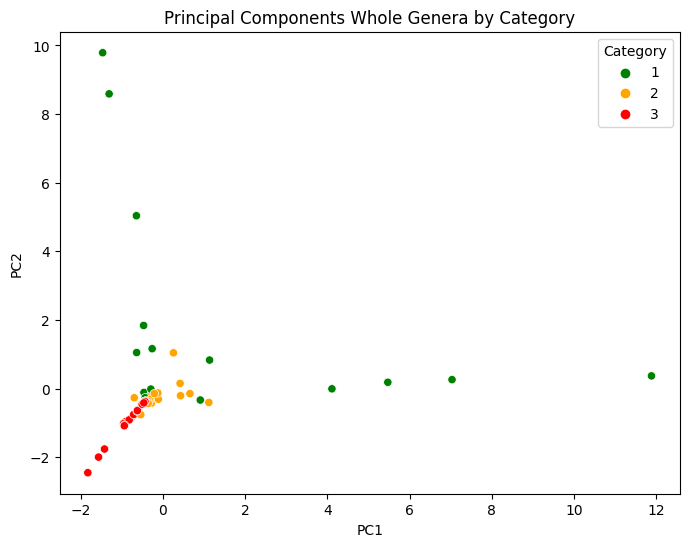

In [8]:

# Create a figure for the plot
plt.figure(figsize=(8, 6))
plt.title('Principal Components Whole Genera by Category')

# Now, plot PC1 vs PC2 and color the points by 'Category'
colors = ['green', 'orange', 'red']  # Replace with your desired colors
sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df_i, palette=colors)

plt.show()

**Influencers Genera Dataframe (`influencers_final`)**:
   - This dataframe, representing the most influential genera both statistically and quantitatively, shows a clearer separation among the categories, especially between category 3 and the others.
   - Category 3 forms a linear pattern between PC1 and PC2, suggesting a gradient or continuum of variance explained by these components.
   - Category 2 dots align at the end of this linear pattern, indicating they share some characteristics with category 3 but also have distinct features.
   - Category 1 displays a 'Y' shape, with category 3 forming the root, category 2 at the intersection, and the two arms of the 'Y' representing the spread of category 1. This pattern might indicate that category 1 encompasses a broader range of variance or interactions compared to the other categories,

In [9]:
#Ensure 'Sites' is String
whole_taxa['Sites'] = whole_taxa['Sites'].astype(str)
whole_taxa = whole_taxa.set_index('Sites')
#Correcting the Tuple-like Index
whole_taxa.index = whole_taxa.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

# Extract the GID columns (excluding 'Site' and 'Category'), # X being feature matrix and y being target variable
X_whole = whole_taxa.drop(columns=['Category'], level=0)

# Standardize the data
X_standardized_whole= StandardScaler().fit_transform(X_whole)
X_standardized_whole = pd.DataFrame(X_standardized_whole, columns=X_whole.columns)


/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


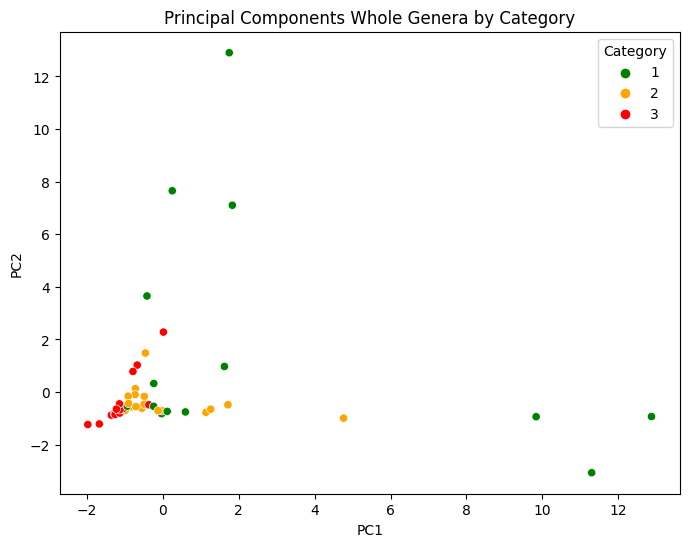

In [10]:
# Compute PCA
pca_whole = PCA(n_components=2)  # We're only taking the first two principal components for visualization
principal_components = pca_whole.fit_transform(X_standardized_whole)

# Convert the principal components to a DataFrame for easier plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Category'] = whole_taxa['Category'].values

# Create a figure for the plot
plt.figure(figsize=(8, 6))
plt.title('Principal Components Whole Genera by Category')

# Now, plot PC1 vs PC2 and color the points by 'Category'
colors = ['green', 'orange', 'red']  # Replace with your desired colors
sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df, palette=colors)

plt.show()

**Whole Data**:
   - The scenario for the whole data is more intricate. The categories are not as distinctly separated, indicating a more complex interplay of features.
   - While category 1 also forms a 'Y' shape, the distinction is less clear due to the overlap with categories 2 and 3. This overlap suggests shared characteristics or interactions among the categories.
   - Category 3, although forming a linear pattern, also has a few dots that spread out, indicating some variability within this category.
   - The mixed pattern observed suggests a more intricate relationship among the categories, possibly due to the inclusion of a broader set of genera in the whole data.
**Interpretation**:
 The distinct linear pattern of category 3 and 1 in both dataframes suggests a consistent underlying structure or set of interactions. However, the whole data presents a more convoluted picture, with overlaps and mixed patterns. This complexity might arise from the inclusion of a broader set of genera, some of which might not be as influential or distinct as the ones in the `influencers_final` dataframe.

### Computing how many features would be necesary to explain the whole data

/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


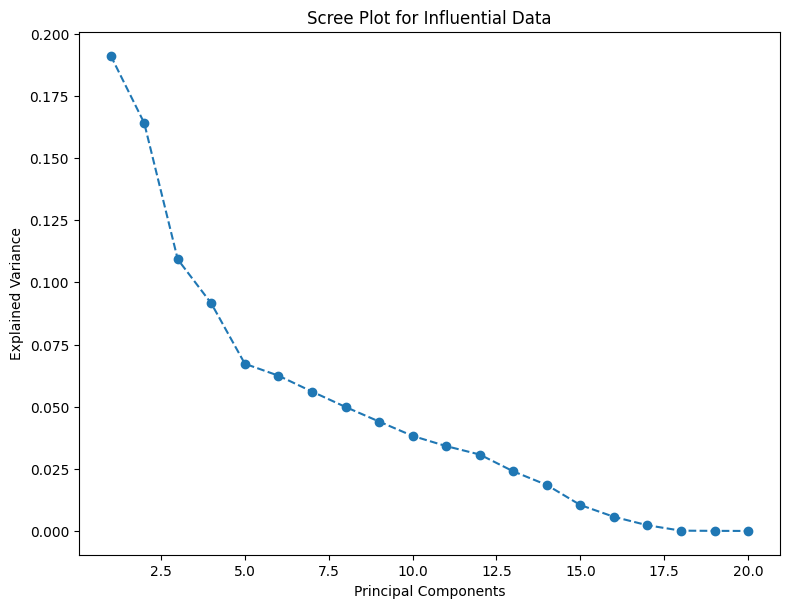

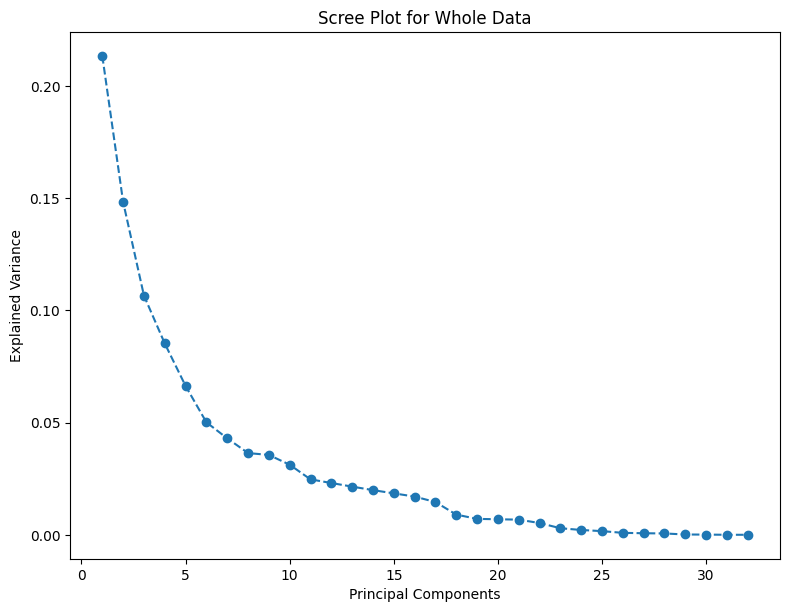

In [11]:
pca_influential_features = PCA()
pca_influential_features.fit(X_standardized_influencers)
explained_variances_influential = pca_influential_features.explained_variance_ratio_

pca_whole_features = PCA()
pca_whole_features.fit(X_standardized_whole )
explained_variances_whole = pca_whole_features.explained_variance_ratio_

def plot_scree(pca, title):
    explained_var = pca.explained_variance_ratio_
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o', linestyle='--')
    plt.ylabel('Explained Variance')
    plt.xlabel('Principal Components')
    plt.tight_layout()
    plt.title(title)
    plt.show()

# Plotting for pca_influential
plot_scree(pca_influential_features, "Scree Plot for Influential Data")

#Plotting for pca_whole
plot_scree(pca_whole_features, "Scree Plot for Whole Data")


1. Influencers Genera:
The PCA plot for the influencers shows distinct clustering, indicating specific patterns within these genera. The first few principal components capture significant variance, suggesting that there are strong underlying structures or patterns in this subset of the data. This could be due to specific biological characteristics or interactions that are more pronounced in these influential genera.

2. Whole Data:
For the entire dataset, the PCA plot displays a more dispersed distribution of data points. The smooth decline in explained variance across principal components suggests that the variance is spread more evenly across the features. This is expected as the whole dataset encompasses a broader range of genera, each contributing to the overall variance.

__Interpretation:__
The distinct patterns observed in the PCA plots can provide insights into the relationships and interactions between different genera. For instance, closely clustered points in the PCA space might indicate genera with similar biological properties or ecological roles. Furthermore, the difference in patterns between the influencers_final and whole data suggests that the influential genera have specific characteristics that set them apart from the rest. This could be of particular interest for further biological investigations, as understanding these key influencers can shed light on crucial microbial interactions or pathways.

In addition to PCA, we also assessed feature importance using a RandomForest model. This analysis ranked the original features based on their predictive power. While PCA highlighted the overall structure of the data, the RandomForest feature importance provided a direct measure of which genera (features) are most influential in predicting our target variable.

## Feature Importance 
Using ramdom forest to get the importance of each feature in the model.

In [13]:
y_influencers = Influencers_taxa["Category"]
# Initialize a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to your data
rf.fit(X_standardized_influencers , y_influencers)

# Extract feature importances
feature_importances = rf.feature_importances_

/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/tmp/ipykernel_4422/17673636.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_standardized_influencers , y_influencers)


In [16]:
# Extract GID and Join_tax from the multi-index
GID = X_Influencers_taxa.columns.get_level_values(5).to_list()
Join_tax = X_Influencers_taxa.columns.get_level_values(0).to_list()

# Create a DataFrame to view the results
df_importances = pd.DataFrame({
    'GID' : GID,
    'Join_tax': Join_tax,
    'Importance': feature_importances
})

# Sort the features by importance
Influencers_importance = df_importances.sort_values(by='Importance', ascending=False)
Influencers_importance["Join_tax"] = Influencers_importance["Join_tax"].str.strip()
pd.set_option('display.max_rows', 100)  # Display up to 500 rows

### Feature Importance using the whole data 
from Notebook Filtering.ipynb after statistical Analyis :  Ordinary Least Squares (OLS) regression analysis.

In [19]:
y_whole = whole_taxa["Category"]
# Initialize a Random Forest model
rf_whole = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to your data
rf_whole.fit(X_standardized_whole, y_whole)

# Extract feature importances
feature_importances = rf_whole.feature_importances_
# Extract GID and Join_tax from the multi-index
GID = X_whole.columns.get_level_values(5).to_list()
Join_tax = X_whole.columns.get_level_values(0).to_list()

# Create a DataFrame to view the results
df_importances_whole = pd.DataFrame({
    'GID' : GID,
    'Join_tax': Join_tax,
    'Importance': feature_importances
})

# Sort the features by importance
whole_importance = df_importances_whole.sort_values(by='Importance', ascending=False)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/tmp/ipykernel_4422/3639793786.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_whole.fit(X_standardized_whole, y_whole)


In [20]:
combined_df = pd.concat([whole_importance, Influencers_importance], axis=1, keys=['Whole', 'Influencers'])

# Convert the dataframe to a markdown table
markdown_table = combined_df.to_markdown()
whole_importance.head()

,GID,Join_tax,Importance
20,Phenylobacterium,Caulobacterales_Caulobacteraceae_Phenylobacterium,0.369214
0,Actinomyces,Actinomycetales_Actinomycetaceae_Actinomyces,0.079804
9,Corynebacterium,Actinomycetales_Corynebacteriaceae_Corynebacte...,0.079592
16,Mycobacterium,Actinomycetales_Mycobacteriaceae_Mycobacterium,0.068494
8,Clostridium,Clostridiales_Clostridiaceae_Clostridium,0.058245


| GID | Join_tax  (Whole_taxa)                                                               | Importance | GID | Join_tax  (Influencers_taxa)                                                               | Importance |
|-----|--------------------------------------------------------------------------|------------|-----|--------------------------------------------------------------------------|------------|
|  91 | Burkholderiales_Comamonadaceae_Aquabacterium                             |    0.137681| 549 | Caulobacterales_Caulobacteraceae_Phenylobacterium                        |    0.413169|
| 725 | Thermales_Thermaceae_Thermus                                             |    0.113029| 526 | Rhodobacterales_Rhodobacteraceae_Paracoccus                              |    0.287534|
| 229 | Actinomycetales_Corynebacteriaceae_Corynebacterium                       |    0.108872| 864 | Clostridiales_Veillonellaceae_Veillonella                                |    0.071474|
| 549 | Caulobacterales_Caulobacteraceae_Phenylobacterium                        |    0.082905| 625 | Rhodospirillales_Acetobacteraceae_Roseococcus                            |    0.065915|
| 214 | Clostridiales_Clostridiaceae_Clostridium                                 |    0.077026| 408 | Legionellales_Legionellaceae_Legionella                                  |    0.036827|
| 140 | Actinomycetales_Dermabacteraceae_Brachybacterium                         |    0.074724| 863 | Burkholderiales_Comamonadaceae_Variovorax                                |    0.033380|
|  23 | Actinomycetales_Actinomycetaceae_Actinomyces                             |    0.072267| 214 | Clostridiales_Clostridiaceae_Clostridium                                 |    0.024378|
| 584 | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas                     |    0.044125| 229 | Actinomycetales_Corynebacteriaceae_Corynebacterium                       |    0.019782|
| 678 | Sphingomonadales_Sphingomonadaceae_Sphingosinicella                      |    0.039156|  91 | Burkholderiales_Comamonadaceae_Aquabacterium                             |    0.015722|
| 470 | Actinomycetales_Mycobacteriaceae_Mycobacterium                           |    0.036138| 351 | Pasteurellales_Pasteurellaceae_Haemophilus                               |    0.014212|
| 337 | Gemmatimonadales_Gemmatimonadaceae_Gemmatimonas                          |    0.026695|  23 | Actinomycetales_Actinomycetaceae_Actinomyces                             |    0.006249|
| 565 | Bacteroidales_Porphyromonadaceae_Porphyromonas                           |    0.024981| 565 | Bacteroidales_Porphyromonadaceae_Porphyromonas                           |    0.003237|
| 334 | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria                    |    0.024166| 334 | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria                    |    0.003216|
| 871 | Rhizobiales_Xanthobacteraceae_Xanthobacter                               |    0.022430| 375 | Rhizobiales_Hyphomicrobiaceae_Hyphomicrobium                             |    0.002534|
| 625 | Rhodospirillales_Acetobacteraceae_Roseococcus                            |    0.018093| 584 | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas                     |    0.001386|
| 771 | Spirochaetales_Spirochaetaceae_Spirochaetaceae_unclassified              |    0.016874| 471 | Caulobacterales_Caulobacteraceae_Mycoplana                               |    0.000985|
| 201 | Actinomycetales_Promicromonosporaceae_Cellulosimicrobium                 |    0.013343| 678 | Sphingomonadales_Sphingomonadaceae_Sphingosinicella                      |    0.000000|
| 657 | Rhizobiales_Rhizobiaceae_Shinella                                        |    0.009457| 712 | Burkholderiales_Comamonadaceae_Tepidimonas                               |    0.000000|
|  88 | Rhizobiales_Rhodobiaceae_Anderseniella                                   |    0.008810| 725 | Thermales_Thermaceae_Thermus                                             |    0.000000|
| 428 | Micrococcales_Microbacteriaceae_Lysinimonas                              |    0.008339| 871 | Rhizobiales_Xanthobacteraceae_Xanthobacter                               |    0.000000|
| 712 | Burkholderiales_Comamonadaceae_Tepidimonas                               |    0.007619|     |                                                                          |            |
|  79 | Thermoanaerobacterales_Thermoanaerobacteraceae_Anaerobacter              |    0.006386|     |                                                                          |            |
| 342 | Nitrosomonadales_Sterolibacteriaceae_Georgfuchsia                        |    0.005122|     |                                                                          |            |
| 605 | Xanthomonadale_Rhodobacteraceae_Rhodanobacter                            |    0.005032|     |                                                                          |            |
| 799 | Rhodocyclales_Rhodocyclaceae_Uncultured_bacterium                        |    0.004187|     |                                                                          |            |
|  92 | Rhizobiales_Phyllobacteriaceae_Aquamicrobium                             |    0.003721|     |                                                                          |            |
| 410 | Micrococcales_Microbacteriaceae_Leifsonia                                |    0.003528|     |                                                                          |            |
| 426 | Oscillatoriales_Oscillatoriaceae_Lyngbya                                 |    0.002889|     |                                                                          |            |
| 480 | Rhizobiales_Phyllobacteriaceae_Nitratireductor                           |    0.001696|     |                                                                          |            |


__Consistency in Top Features:__ Both datasets identified Phenylobacterium as the most influential feature. This consistency suggests that this genus plays a pivotal role in the dataset, regardless of the data's granularity.
Variability in Other Features: Beyond the top feature, there's a noticeable divergence in the ranking of genera between the two datasets. This is expected given the different preprocessing steps applied to each dataset.

__Biological Significance:__ The consistent identification of Phenylobacterium in both datasets underscores its potential biological significance. It might be worthwhile to delve deeper into the biological properties or ecological roles of this genus.
__Influence of Data Granularity:__ The influencers genera dataset, being a filtered subset, might capture more specific interactions or characteristics that are overshadowed in the whole dataset. On the other hand, the whole dataset provides a broader perspective, encompassing a wider range of genera interactions.
__Consideration of Other Important Features:__ While the influencers genera dataset offers a more focused view, it might be prudent to consider some of the top features from the whole data. Some of these features, though not present in the filtered dataset, might still play a significant role in the broader microbial community.

__Data Preprocessing:__ The difference in feature importance rankings between the two datasets underscores the impact of data preprocessing. While filtering out low-abundance genera can reduce noise, it might also inadvertently remove genera that play crucial roles in specific contexts.
__Incorporating Biological Knowledge:__ Feature importance derived from machine learning models should be interpreted in conjunction with biological knowledge. For instance, if a genus known to play a vital role in a particular microbial interaction is ranked low, it might be worth revisiting the data or the model.
__Complementary Analysis:__ Consider performing other analyses, like network analysis or pathway enrichment, to gain more insights into the interactions between these top-ranking genera. This can provide a more holistic view of the microbial community's dynamics.
In conclusion, while both datasets offer valuable insights, a balanced approach that considers both the focused view of the influencers and the broader perspective of the whole data might yield the most comprehensive understanding of the microbial community.

I could try to make a combination of the two datasets so to capture all the possible influence from these features, however the problem I see with the combination fo the whole and influencers dataframes is the overlaping of 1 and 3 categories. In the influencers at least there is no this problem, as we can see in the pc1 vs pca2 visualisation. On the other hand there maybe data that I discarded because of abundance and can actually be really good marker, even if trace occurence. 

I am ploting a combination of the two df to visually compare the distribution of each feature across both datasets. Features that have significantly different distributions between the two datasets might be causing the observed differences in PCA or RandomForestRegression results.

In [21]:
Influencers_taxa 

,Category,Rhodospirillales_Acetobacteraceae_Roseococcus,Burkholderiales_Comamonadaceae_Tepidimonas,Caulobacterales_Caulobacteraceae_Phenylobacterium,Legionellales_Legionellaceae_Legionella,Burkholderiales_Comamonadaceae_Variovorax,Bacteroidales_Porphyromonadaceae_Porphyromonas,Caulobacterales_Caulobacteraceae_Mycoplana,Actinomycetales_Corynebacteriaceae_Corynebacterium,Thermales_Thermaceae_Thermus,...,Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas,Pasteurellales_Pasteurellaceae_Haemophilus,Clostridiales_Clostridiaceae_Clostridium,Rhizobiales_Hyphomicrobiaceae_Hyphomicrobium,Sphingomonadales_Sphingomonadaceae_Sphingosinicella,Burkholderiales_Comamonadaceae_Aquabacterium,Rhodobacterales_Rhodobacteraceae_Paracoccus,Actinomycetales_Actinomycetaceae_Actinomyces,Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria,Rhizobiales_Xanthobacteraceae_Xanthobacter
,Phylum,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Bacteroidetes,Proteobacteria,Actinobacteria,Thermi,...,Proteobacteria,Proteobacteria,Firmicutes,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Actinobacteria,Firmicutes,Proteobacteria
,Class,Alphaproteobacteria,Betaproteobacteria,Alphaproteobacteria,Gammaproteobacteria,Betaproteobacteria,Bacteroidia,Alphaproteobacteria,Actinobacteria,Deinococci,...,Gammaproteobacteria,Gammaproteobacteria,Clostridia,Alphaproteobacteria,Alphaproteobacteria,Betaproteobacteria,Alphaproteobacteria,Actinobacteria,Clostridia,Alphaproteobacteria
,Order,Rhodospirillales,Burkholderiales,Caulobacterales,Legionellales,Burkholderiales,Bacteroidales,Caulobacterales,Actinomycetales,Thermales,...,Vibrionales,Pasteurellales,Clostridiales,Rhizobiales,Sphingomonadales,Burkholderiales,Rhodobacterales,Actinomycetales,Thermoanaerobacterales,Rhizobiales
,Familia,Acetobacteraceae,Comamonadaceae,Caulobacteraceae,Legionellaceae,Comamonadaceae,Porphyromonadaceae,Caulobacteraceae,Corynebacteriaceae,Thermaceae,...,Pseudoalteromonadaceae,Pasteurellaceae,Clostridiaceae,Hyphomicrobiaceae,Sphingomonadaceae,Comamonadaceae,Rhodobacteraceae,Actinomycetaceae,Thermoanaerobacteraceae,Xanthobacteraceae
,Genus,Roseococcus,Tepidimonas,Phenylobacterium,Legionella,Variovorax,Porphyromonas,Mycoplana,Corynebacterium,Thermus,...,Pseudoalteromonas,Haemophilus,Clostridium,Hyphomicrobium,Sphingosinicella,Aquabacterium,Paracoccus,Actinomyces,Gelria,Xanthobacter
,GID,625,712,549,408,863,565,471,229,725,...,584,351,214,375,678,91,526,23,334,871
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1508,0.0000,0.0000,0.0000
site_10,2,0.0000,0.0000,0.0000,2.4800,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,2.4200,0.0000,0.0000,0.0000,0.0000
site_11,3,0.0000,0.0000,0.0000,0.2047,0.0000,0.0000,5.8839,11.9724,0.0000,...,0.0767,0.0000,0.9210,0.0000,0.0000,0.0000,0.0767,0.0000,0.0000,0.0000


In [25]:
Influencers_taxa.columns = Influencers_taxa.columns.droplevel([1,2,3,4,5,6])
whole_taxa.columns = whole_taxa.columns.droplevel([1,2,3,4,5,6])

IndexError: Too many levels: Index has only 1 level, not 2

In [ ]:
selected_columns = df.xs(key=("Sites", "Category"), axis=1, level=0)

KeyError: ('Sites', 'Category')

In [ ]:
# Melt the dataframe to long format
df_melted = df.melt(id_vars=["Sites", "Category"], 
                    value_vars=df.columns[2:], 
                    var_name="GID", 
                    value_name="Value")

In [ ]:
# Melt the dataframe to long format
df_melted = df.melt(id_vars=["Sites", "Category"], 
                    value_vars=df.columns[2:], 
                    var_name="GID", 
                    value_name="Value")

colors = ['green', 'orange', 'red']  

# Custom plotting function
def scatterplot(x, y, **kwargs):
    sns.scatterplot(x=x, y=y, **kwargs)

# Create facet grid of plots
g = sns.FacetGrid(df_melted, col="GID", col_wrap=4, sharey=False, hue="Category", palette=colors, height=4)
g.map(scatterplot, "Category", "Value")

# Add x-axis labels
g.set_axis_labels("Category", "Value")
plt.show()

KeyError: "The following 'id_vars' are not present in the DataFrame: ['Sites']"